## Quantum KNN

A lo largo de este notebook vamos a enseñar de forma sencilla como implementar la versión cuántica del KNN. En este ejemplo, utilizaremos el computador cuántico a modo de feature map para poder aplicar los datos en un nuevo espacio. 

Lo primero de todo será generar el dataset con el que vamos a trabajar. Dispondremos de puntos tipo A (naranjas) y tipo B (azules), que siguen una distribución normal.

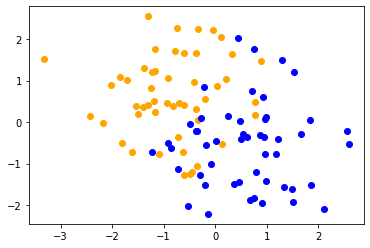

In [1]:
import pennylane as qml
from pennylane import numpy as np 
import matplotlib.pyplot as plt

np.random.seed(42)

n_samples = 200

A_train = np.array([[np.random.normal(loc=-0.7), np.random.normal(loc=0.7)] for i in range(n_samples//4)]) 
B_train = np.array([[np.random.normal(loc=0.7), np.random.normal(loc=-0.7)] for i in range(n_samples//4)]) 

train_labels = ["A"] * (n_samples // 4) + ["B"] * (n_samples // 4)

A_test = np.array([[np.random.normal(loc=-0.7), np.random.normal(loc=0.7)] for i in range(n_samples//4)]) 
B_test = np.array([[np.random.normal(loc=0.7), np.random.normal(loc=-0.7)] for i in range(n_samples//4)]) 

test_labels = ["A"] * (n_samples // 4) + ["B"] * (n_samples // 4)

plt.scatter(A_train[:,0], A_train[:,1], color = "orange")
plt.scatter(B_train[:,0], B_train[:,1], color = "blue")

plt.show()

El siguiente de los pasos es por un lado mapear nuestro dataset a un nuevo espacio a través del computador y después calcular la distancia entre los estados. En particular, como ya vimos en [este video](https://youtu.be/tpPQCtBmRbc), la formula de la distancia es:

$$d(x_1,x_2)=2-2\vert\langle\phi(x_1)\vert\phi(x_2)\rangle\vert^2$$

Por lo tanto, lo que haremos será calcular $\vert\langle\phi(x_1)\vert\phi(x_2)\rangle\vert^2$ a través de [Swap-Test](https://youtu.be/V43R-26NtUU) y sustituir en la distancia.

In [2]:
def feature_map(x, wires):

    qml.RY(x[0], wires = wires[0])
    qml.RY(x[1], wires = wires[1])
    
# |<x1|x2>|^2

dev = qml.device("default.qubit", wires = 5)

@qml.qnode(dev)
def swap_test(x1,x2):
    
    feature_map(x1, wires = [1,2])
    feature_map(x2, wires = [3,4])
    
    qml.Hadamard(wires = 0)
    qml.CSWAP(wires = [0,1,3])
    qml.CSWAP(wires = [0,2,4])
    qml.Hadamard(wires = 0)
    
    return qml.expval(qml.PauliZ(0))
    
def distance(x1, x2):
    return 2 - 2 * swap_test(x1,x2)

# Para ver que funciona, calcularemos la distancia entre dos puntos

distance(A_train[0], A_train[1])

tensor(1.09554785, requires_grad=True)

Una vez que hemos definido la distancia, podemos utilizarla como nueva métrica del KNN, por lo que haremos uso de la librería `sklearn` para llevarlo a cabo de forma sencilla.

In [3]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3,metric=distance)

neigh.fit(np.concatenate([A_train,B_train]),train_labels)
neigh.score(np.concatenate([A_test,B_test]), test_labels)

0.77

Genial! Hemos conseguido un $77\%$ de precisión con este feature map!

Prueba a cambiar el feature map a ver si consigues mejorar estos valores :)